## <span style="color:#08088A">  Settings  </span>

### <span style="color:#08088A">  Needed libraries  </span>

In [1]:
import imdb
import numpy as np
import pandas as pd
import scipy as sp
import sklearn.neighbors as knn
import matplotlib
import matplotlib.pyplot as plt
import seaborn
import requests
import urllib
import joblib
import requests
import json
import os
import random
#import statsmodels.api as sm
from matplotlib import rcParams
from sklearn import discriminant_analysis
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from scipy.stats import mode
from sklearn import linear_model
from IPython.core.interactiveshell import InteractiveShell
from time import sleep
from collections import Counter
from itertools import combinations, permutations
from urlparse import urljoin
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [2]:
matplotlib.style.use('ggplot')
rcParams['figure.figsize'] = (20, 10)
rcParams['axes.facecolor'] = "w"
rcParams['grid.color'] = "gray"
rcParams['grid.linewidth'] = 0.5

### <span style="color:#08088A">  API settings  </span>

In [ ]:
api_key='put_your_api_key#' ## insert your API Keys do not use mine 

In [ ]:
# setting for the discorver
movie_endpoint = 'http://api.themoviedb.org/3/movie/{movie_id}'
endpoint = 'http://api.themoviedb.org/3/discover/movie'

discover_params = {
        'sort_by':              'popularity.desc',
        'primary_release_year':  2016
        }
random_params = {
            'api_key'             :  'api_key',
            }



### <span style="color:#08088A">  Needed functions  </span>

In [4]:
def imdb_id_from_title(title):
    """ return IMDB id for search string

        Args::
            title (str): the movie title search string

        Returns: 
            str. IMDB id, e.g., 'tt0095016' 
            None. If no match was found

    """
    pattern = 'http://www.imdb.com/xml/find?json=1&nr=1&tt=on&q={movie_title}'
    url = pattern.format(movie_title=urllib.quote(title))
    r = requests.get(url)
    res = r.json()
    sleep(0.5)
    # sections in descending order or preference
    for section in ['popular','exact','substring']:
        key = 'title_' + section 
        if key in res:
            return res[key][0]['id']

In [ ]:
def discover_tmdb_movies(max_pages, discover_params):
    
    
    
    discover_params.update(api_key = api_key)

    total_pages = json.loads(requests.get(endpoint, params = discover_params).text)['total_pages']

    movie_list = []
    for page_num in range(1, total_pages+1):
        if page_num > max_pages:
            break

        discover_params.update(page = page_num)
        reponse = requests.get(endpoint, params = discover_params)
        movie_list.extend(json.loads(reponse.text)['results'])
        sleep(0.06)

    return movie_list


In [ ]:
def get_random_tmdb_movies(max_pages):
   
    
    
    random_params.update(api_key = api_key)
    movie_list = []
    for page_num in range(1, max_pages+1):
        random_year = random.choice(range(1990, 2018))
        
        random_params.update(primary_release_year=random_year)
        
        total_pages = json.loads(requests.get(endpoint, params = random_params).text)['total_pages']
        random_result_page  =  random.choice(range(1, total_pages+1))
        discover_params.update({'page':  random_result_page})
        
        reponse = requests.get(endpoint, params = random_params)
        movie_list.extend(json.loads(reponse.text)['results'])
        sleep(0.06)

    return movie_list
    

In [ ]:
def get_movie_info_from_tmdbid(tmdbid):
    sleep(0.05)
    response = requests.get(movie_endpoint.format(movie_id = tmdbid), params = {'api_key':api_key})
    return json.loads(response.text)

## <span style="color:#08088A">  Stage 1: Ask A Question  </span>

The exact form of X and Y depends on the ideas you had previously. In general though Y should involve the genre of a movie, and X the features you want to include to predict the genre. Remember from the lecture that more features does not necessarily equal better prediction performance. Use your application knowledge and the insight you gathered from your genre pair analysis and additional EDA to design Y. Do you want to include all genres? Are there genres that you assume to be easier to separate than others? Are there genres that could be grouped together? There is no one right answer here. We are looking for your insight, so be sure to describe your decision process in your notebook.
In preparation for the deep learning part we strongly encourage you to have two sets of training data X, one with the metadata and one with the movie posters. Make sure to have a common key, like the movie ID, to be able to link the two sets together. Also be mindful of the data rate when you obtain the posters. Time your requests and choose which poster resolution you need. In most cases w500 should be sufficient, and probably a lower resolution will be fine.
The notebook to submit this week should at least include:
Discussion about the imbalanced nature of the data and how you want to address it
Description of your data
What does your choice of Y look like?
Which features do you choose for X and why?
How do you sample your data, how many samples, and why?

## <span style="color:#08088A"> Stage 2: Get the Data  </span>

##  <span style="color:#08088A">  Movie Data:  </span> 


The project is based on two different sources of movie data: IMDb and TMDb. TMDb is great, because it provides the movie posters in addition to the metadata. This is crucial for the deep learning part, in which you will try to predict movie genres from posters. IMDb has more metadata available and will supplement the TMDb data you have.
TMDb provides an easy to use API that allows you to download the data selectively. IMDb does not provide an API, but there is a Python interface available to access the metadata. We will use IMDbPY, which is already installed on the AMI and virtual box images for your convenience.


###  <span style="color:#08088A">  Tmdb movie Data:  </span> 

In [3]:
# contains limited information about the movies from the discovered end point
#discover_movie_list = discover_tmdb_movies(1, discover_params)
random_movie_list = get_random_tmdb_movies(400)

##getting complete info from the movie end point (about discovered movies)


# with a for loop

movie_info_list = [] # movies list form TMDB
for index, movie in enumerate(random_movie_list):
    #print '\b' + str(index)
    movie_info_list.append(get_movie_info_from_tmdbid(movie['id']))
    sleep(0.05)


# with a for map function
#movie_info_list = map(get_movie_info_from_tmdbid, [movie['id'] for movie in random_movie_list])

movie_info_list[:] = [x for x in movie_info_list if x['imdb_id'] != '' and x['imdb_id'] != None]

In [3]:
movie_info_list[:] = [x for x in movie_info_list if x['imdb_id'] != '' and x['imdb_id'] != None]
joblib.dump(movie_info_list, 'movie_info_list.pkl')
movie_info_list = joblib.load('movie_info_list.pkl')

In [ ]:
data_tmdb = pd.DataFrame(movie_info_list)

Some movies in tmdb dataset don't have imbd ID. To avoid error when requesting the imbd database, we will remove them.

In [ ]:
len(data_tmdb), len(data_tmdb.imdb_id.unique())

In [ ]:
len(movie_info_list)

In [ ]:
data_tmdb['modified_genres'] = data_tmdb.genres.map(lambda x: [ [n for m,n in genre.items() if m == 'name'] for genre in x])
data_tmdb['modified_genres'] = data_tmdb['modified_genres'].map(lambda l: [genre for genre_list in l for genre in genre_list ])
data_tmdb[['original_title', 'modified_genres']].head()

###  <span style="color:#08088A">  Imdb movie Data:  </span> 

In [8]:
handle = imdb.IMDb('http')
imdb_movie_list = []

for imdbID in [x['imdb_id'] for x in movie_info_list]:
    
    imdb_movie_list.append(handle.get_movie(imdbID[2:len(imdbID)]))
    sleep(0.05)

In [9]:
imdb_movie_list_1 = [{k: x[k] for k in ('title', 'genres')} for x in imdb_movie_list[0:10]]

In [10]:
data_imdb = pd.DataFrame(imdb_movie_list_1)

In [11]:
data_imdb.head()

,genres,title
0,"[Animation, Comedy, Family, Music]",Sing
1,"[Action, Adventure, Sci-Fi]",Rogue One
2,"[Adventure, Family, Fantasy]",Fantastic Beasts and Where to Find Them
3,"[Animation, Adventure, Comedy, Family]",Finding Dory
4,"[Action, Adventure, Comedy, Romance, Sci-Fi]",Deadpool
5,"[Drama, Mystery, Sci-Fi, Thriller]",Arrival
6,"[Action, Adventure, Sci-Fi]",Captain America: Civil War
7,"[Action, Adventure, Fantasy, Sci-Fi]",Doctor Strange
8,"[Action, Horror]",Underworld: Blood Wars
9,[Comedy],Why Him?


###  <span style="color:#08088A">  Merged Data:  </span> 

In [ ]:
# we have to merge two infos- movie_info_list and imdb_movie_list
# get all fields for movie - movie_info_list[1].keys()

imdb_info_subset = ['imdb_id', 'title', 'year', 'genres']
tmdb_info_subset = ['imdb_id', 'overview', 'budget', 'genres', 'poster_path']

# prepare imdb data list

[x.data.update({'imdb_id': 'tt' + x.getID()}) for x in imdb_movie_list]
extracted_imdb_movie_list = [x.data for x in imdb_movie_list]

## subset fields for imdb and tmdb lists

final_tmdb_list = [ {x:y for x, y in movie.items() if x in tmdb_info_subset} for movie in movie_info_list]
final_imdb_list = [ {x:y for x, y in movie.items() if x in imdb_info_subset} for movie in extracted_imdb_movie_list]

tmdb_df = pd.DataFrame(final_tmdb_list)
imdb_df = pd.DataFrame(final_imdb_list)

## convert genre dictionary to list
tmdb_df['genres'] = tmdb_df.genres.map(lambda x: [ [n for m,n in genre.items() if m == 'name'] for genre in x])
tmdb_df['genres'] = tmdb_df['genres'].map(lambda l: [genre for genre_list in l for genre in genre_list ])


merged_mdb = pd.merge(tmdb_df, imdb_df, on='imdb_id')

###  <span style="color:#08088A">  EDA:  </span> 

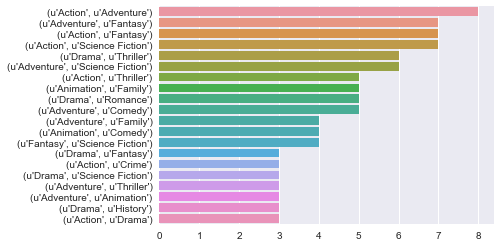

In [17]:
# genre paired occurence

paired_genres = list(data_tmdb.modified_genres.map(lambda x : list(combinations(x, 2))))
flattened_genre_pairs = [pair for sublist in paired_genres for pair in sublist]
pair_counter = Counter(flattened_genre_pairs)
count_pair_list = zip(pair_counter, pair_counter.values())

sorted_count_pair_list = sorted(count_pair_list, key= lambda x: x[1], reverse=True)[0:20]

seaborn.barplot([x[1] for x in sorted_count_pair_list],[str(x[0]) for x in sorted_count_pair_list] )

In [24]:
data_tmdb['pairs'] = data_tmdb.modified_genres.map(lambda x : list(combinations(x, 2)))
melted_genre_pairs_movie = pd.DataFrame(pd.concat([pd.Series(row['original_title'], row['pairs']) for x, row in data_tmdb.iterrows()])).reset_index()

In [37]:
melted_genre_pairs_movie.columns = ['genre_pair', 'original_title']
# melted_genre_pairs_movie.head(20)
grouped_genre_pairs_movie = melted_genre_pairs_movie.groupby('genre_pair')['original_title'].agg({'titles': lambda x : ', '.join(x)}).reset_index()
grouped_genre_pairs_movie.columns = ['genre_pair', 'titles']

plot_data = pd.DataFrame(sorted_count_pair_list, columns=['genre_pair', 'count'])

In [ ]:
merged_data = pd.merge(plot_data, grouped_genre_pairs_movie, on = 'genre_pair', how= 'inner')